This notebook loads the crack data into Datasets and DataLoaders that are compatible for training. The code is saved to `~/scripts/ImageFolder.py` for easy import.

In [199]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

I created a new folder for `val` and moved 50 random sequences from the `train` folder into `val`.

In [200]:
# Set data paths
data_root = '../data/cracks_s_nb'
train_path = os.path.join(data_root, "train")
test_path = os.path.join(data_root, "test")
val_path = os.path.join(data_root, "val")

## Create ImageFolder Class

In [201]:
# load from folder
class ImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.imgs = []
        for root, dirs, files in os.walk(root):
            for file in files:
                if file.endswith(".png"):
                    self.imgs.append(os.path.join(root, file))
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.imgs[index]
        img = Image.open(img_path)
        # img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.imgs)
    
    # sourced from https://github.com/wherobots/GeoTorchAI/blob/main/geotorchai/datasets/grid/processed.py
    def set_sequential_representation(self, history_length, predict_length):
        '''
        Call this method if you want to iterate the dataset as a sequence of histories and predictions instead of closeness, period, and trend.

        Parameters
        ..........
        history_length (Int) - Length of history data in sequence of each sample
        predict_length (Int) - Length of prediction data in sequence of each sample
        '''

        history_data = []
        predict_data = []
        seq_length = history_length + predict_length
        total_length = len(self.imgs)
        for end_idx in range(history_length + predict_length, total_length, seq_length):
            history_idx = list(range(end_idx-predict_length-history_length, 
                                     end_idx-predict_length))
            predict_idx = list(range(end_idx-predict_length, 
                                     end_idx))

            history_frames = [np.array(self.__getitem__(idx)) for idx in history_idx]
            predict_frames = [np.array(self.__getitem__(idx)) for idx in predict_idx]
            
            history_data.append(history_frames)
            predict_data.append(predict_frames)

        history_data = np.stack(history_data)
        predict_data = np.stack(predict_data)

        self.X_data = torch.tensor(history_data)
        self.Y_data = torch.tensor(predict_data)

### Try it out with train set

In [202]:
train = ImageFolder(root=train_path, transform=transforms.ToTensor())
train.set_sequential_representation(history_length=5, predict_length=1)
train.X_data.shape, train.Y_data.shape

(torch.Size([363, 5, 1, 128, 128]), torch.Size([363, 1, 1, 128, 128]))

In [203]:
train.imgs[:10]

['../data/cracks_s_nb/train/108_1_0/2016.png',
 '../data/cracks_s_nb/train/108_1_0/2014.png',
 '../data/cracks_s_nb/train/108_1_0/2015.png',
 '../data/cracks_s_nb/train/108_1_0/2011.png',
 '../data/cracks_s_nb/train/108_1_0/2012.png',
 '../data/cracks_s_nb/train/108_1_0/2013.png',
 '../data/cracks_s_nb/train/21_1_0/2016.png',
 '../data/cracks_s_nb/train/21_1_0/2014.png',
 '../data/cracks_s_nb/train/21_1_0/2015.png',
 '../data/cracks_s_nb/train/21_1_0/2011.png']

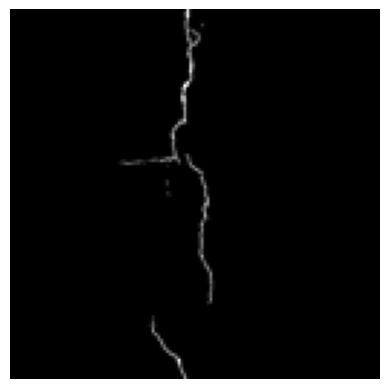

In [204]:
# Use plt to show one of the images
plt.imshow(train[0].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

In [205]:
train.__getitem__(0)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [206]:
train.__getitem__(0).shape

torch.Size([1, 128, 128])

In [207]:
print(train.__len__())

2184


### Try it out with test set

In [208]:
test = ImageFolder(root=test_path, transform=transforms.ToTensor())
test.set_sequential_representation(history_length=5, predict_length=1)
test.X_data.shape, test.Y_data.shape

(torch.Size([103, 5, 1, 128, 128]), torch.Size([103, 1, 1, 128, 128]))

In [209]:
test.imgs[:10]

['../data/cracks_s_nb/test/17_0_1/2016.png',
 '../data/cracks_s_nb/test/17_0_1/2014.png',
 '../data/cracks_s_nb/test/17_0_1/2015.png',
 '../data/cracks_s_nb/test/17_0_1/2011.png',
 '../data/cracks_s_nb/test/17_0_1/2012.png',
 '../data/cracks_s_nb/test/17_0_1/2013.png',
 '../data/cracks_s_nb/test/35_1_0/2016.png',
 '../data/cracks_s_nb/test/35_1_0/2014.png',
 '../data/cracks_s_nb/test/35_1_0/2015.png',
 '../data/cracks_s_nb/test/35_1_0/2011.png']

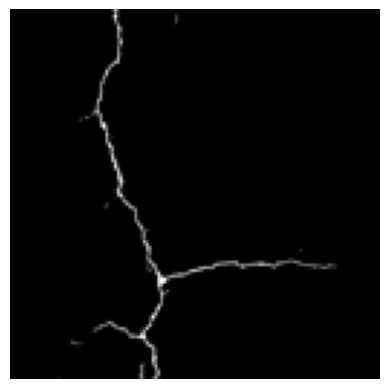

In [210]:
# Use plt to show one of the images
plt.imshow(test[0].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

In [211]:
test.__getitem__(0)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [212]:
test.__len__()

624

### Try it out with validation set

In [213]:
val = ImageFolder(root=val_path, transform=transforms.ToTensor())
val.set_sequential_representation(history_length=5, predict_length=1)
val.X_data.shape, val.Y_data.shape

(torch.Size([49, 5, 1, 128, 128]), torch.Size([49, 1, 1, 128, 128]))

In [214]:
val.imgs[:10]

['../data/cracks_s_nb/val/122_1_1/2016.png',
 '../data/cracks_s_nb/val/122_1_1/2014.png',
 '../data/cracks_s_nb/val/122_1_1/2015.png',
 '../data/cracks_s_nb/val/122_1_1/2011.png',
 '../data/cracks_s_nb/val/122_1_1/2012.png',
 '../data/cracks_s_nb/val/122_1_1/2013.png',
 '../data/cracks_s_nb/val/135_1_0/2016.png',
 '../data/cracks_s_nb/val/135_1_0/2014.png',
 '../data/cracks_s_nb/val/135_1_0/2015.png',
 '../data/cracks_s_nb/val/135_1_0/2011.png']

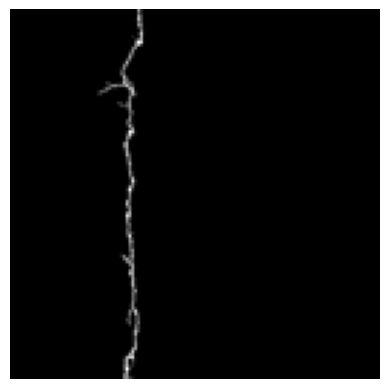

In [215]:
# Use plt to show one of the images
plt.imshow(val[0].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

In [216]:
val.__getitem__(0)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [217]:
val.__len__()

300

## Usage with DataLoader

In [218]:
class ImageDataset(ImageFolder):
    def __init__(self, ds):
        self.X_data = ds.X_data
        self.Y_data = ds.Y_data

    def __getitem__(self, index):
        x_data = self.X_data[index]
        y_data = self.Y_data[index]
        
        # Returning a dictionary containing data elements
        return {"X_data": x_data, "Y_data": y_data}

    def __len__(self):
        return len(self.X_data)

In [219]:
batch_size = 32
params = {'batch_size': batch_size, 'shuffle': False, 'drop_last':False, 'num_workers': 0}

In [220]:
train = ImageFolder(root=train_path, transform=transforms.ToTensor())
test = ImageFolder(root=test_path, transform=transforms.ToTensor())
val = ImageFolder(root=val_path, transform=transforms.ToTensor())

train.set_sequential_representation(history_length=5, predict_length=1)
test.set_sequential_representation(history_length=5, predict_length=1)
val.set_sequential_representation(history_length=5, predict_length=1)

train_generator = DataLoader(ImageDataset(train), **params)
test_generator = DataLoader(ImageDataset(test), **params)
val_generator = DataLoader(ImageDataset(val), **params)